## Glioma Enhancer selection

In [3]:
#FeatureSelectionByMultilevelEnrichmentImports
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from collections import Counter
from tqdm import tqdm
import warnings

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.plotting.marker_plot import marker_plot
from chromograph.plotting.peak_annotation_plot import plot_peak_annotation_wheel
from chromograph.pipeline import config

import cytograph as cg
from cytograph.plotting.colors import colorize
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species

from typing import *

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import loompy
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.spatial.distance import jaccard

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

config = config.load_config()
sys.path.append("/home/camiel/anaconda3/envs/chromo/bin/")

In [30]:
## Files
# f = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_peaks.loom'
# f_agg = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_peaks.agg.loom'
# binfile = '/proj/DEV_ATAC/Kriegstein_20200729/All/All.loom'
# f_GA = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_GA.loom'
# f_GA_agg = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_GA.agg.loom'
# f_motif = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_motifs.loom'

f_dir = '/proj/DEV_ATAC/GBM_20210316/WTIDH1'
subset = 'WTIDH1'
date = '20210323'
files = [f"{subset}_peaks.loom",
        f"{subset}_peaks.agg.loom",
        f"{subset}.loom",
        f"{subset}_prom.loom",
        f"{subset}_prom.agg.loom",
        f"{subset}_motifs.loom"]
f, f_agg, binfile, f_GA, f_GA_agg, f_motif = [os.path.join(f_dir, x) for x in files]

## Plot markers

(19901, 12735)


/home/camiel/chromograph/chromograph/plotting/marker_plot.py:54: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(np.ceil(nM/4), 4, i)


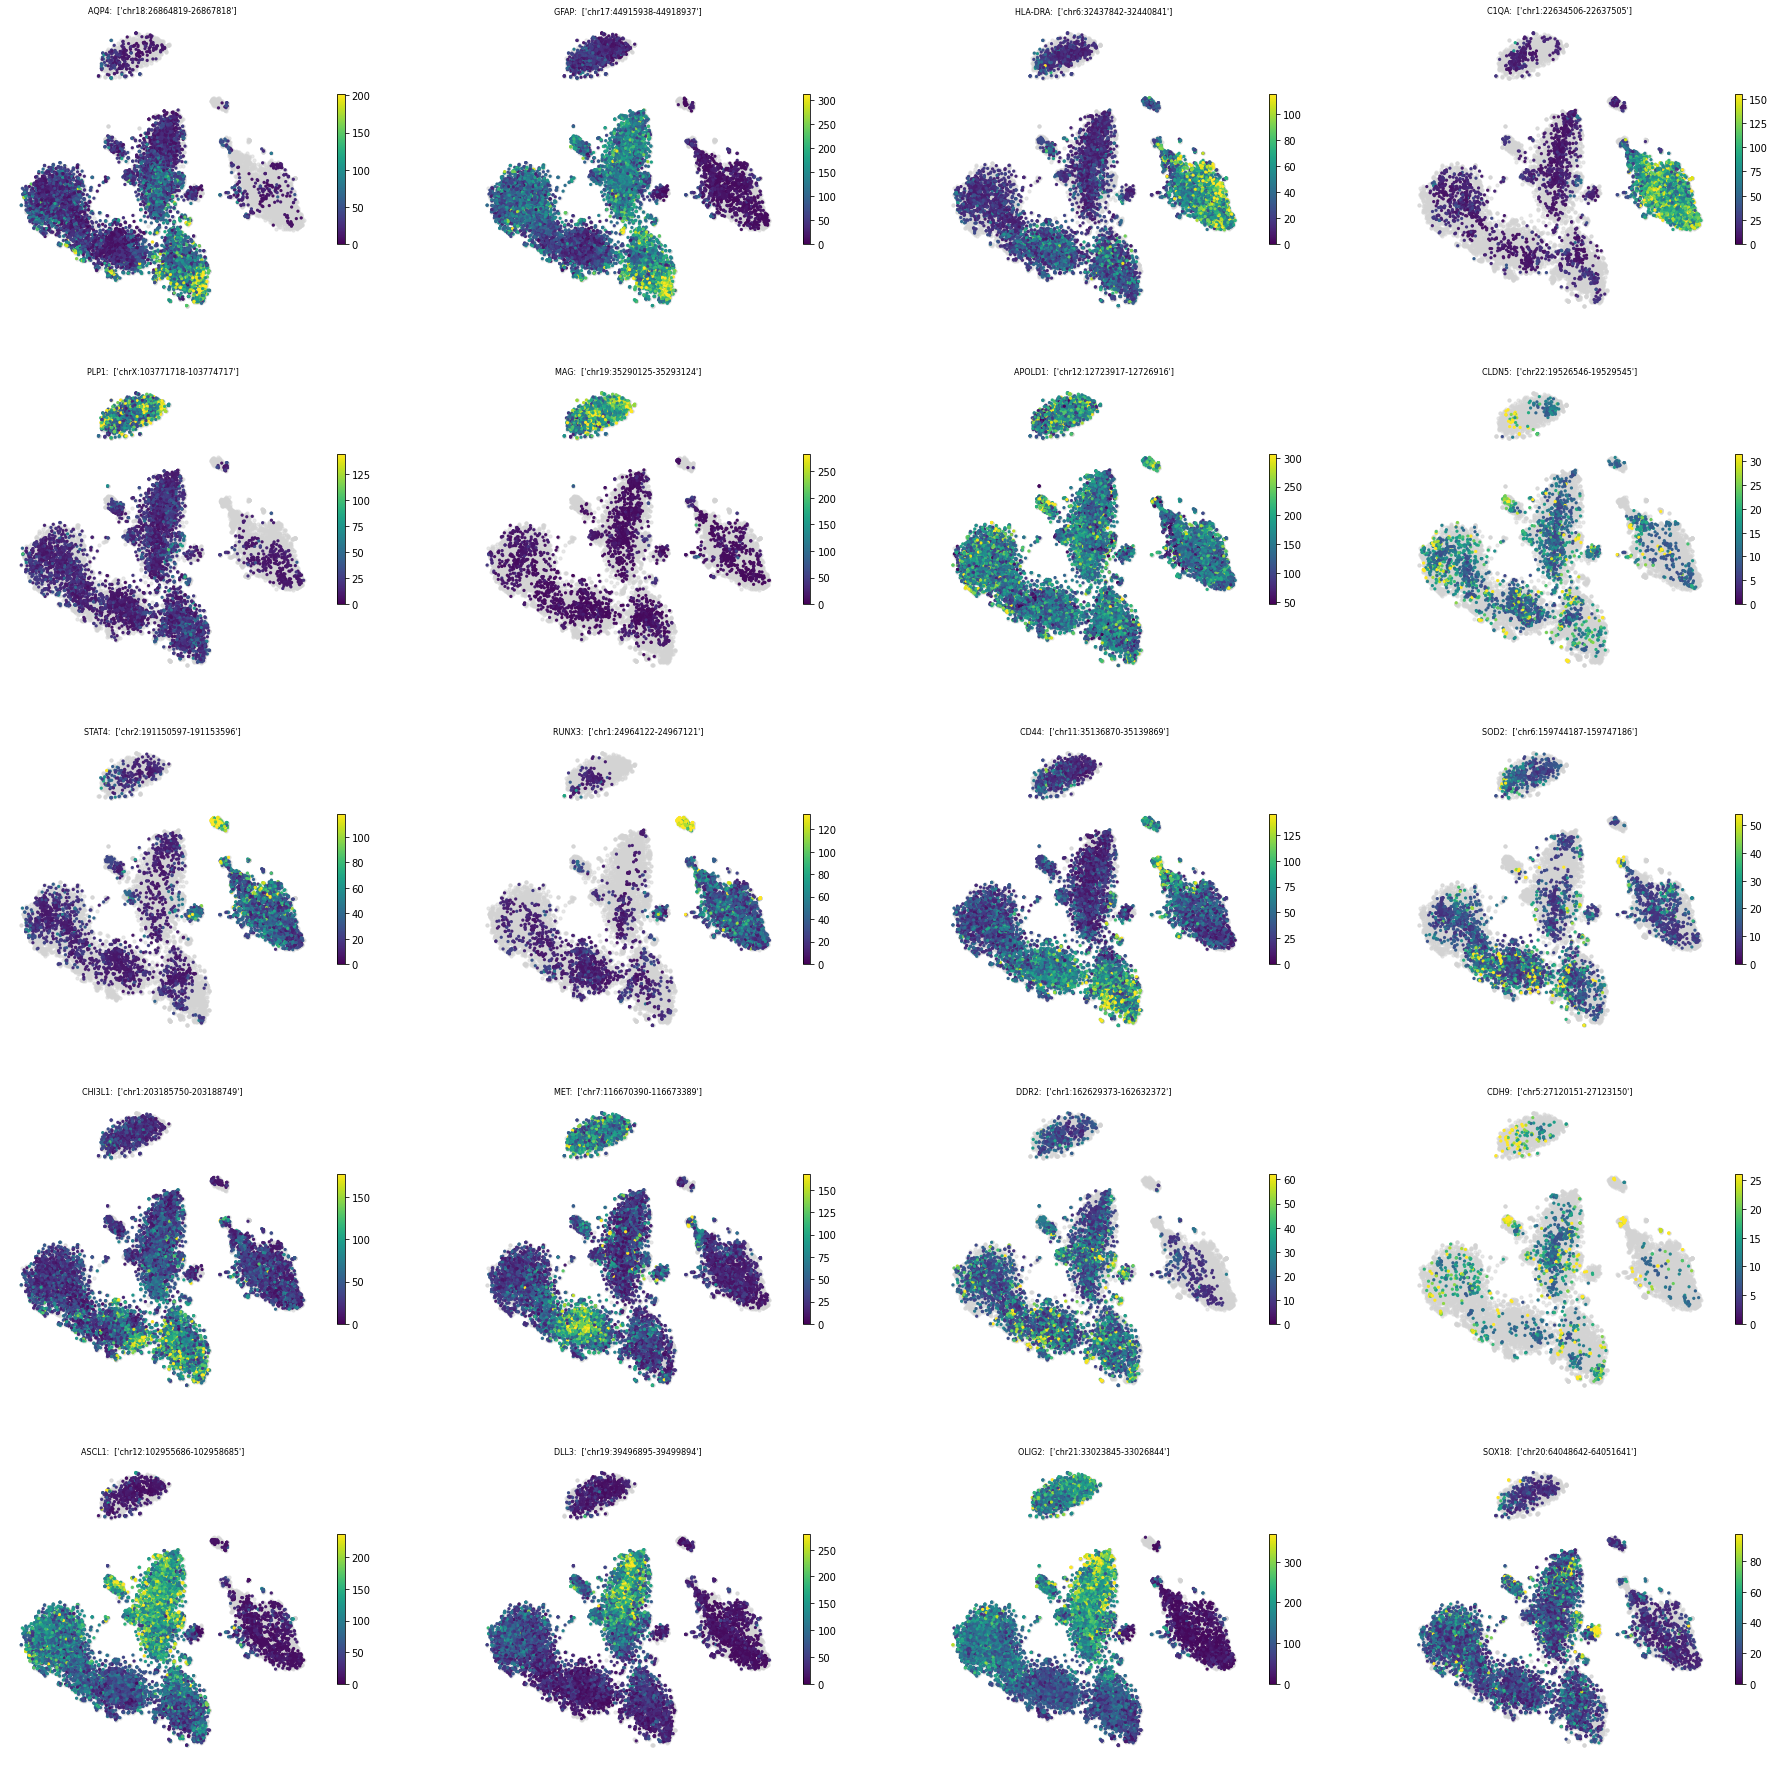

In [5]:
## Markers
markers = ['AQP4', 'GFAP', ## Astrocyte
           'HLA-DRA', 'C1QA', ## Myeloid
           'PLP1', 'MAG', ## Oligodendrocyte
           'APOLD1', 'CLDN5', ## Endothelial
           'STAT4', 'RUNX3', ## Pericytes
           'CD44', 'SOD2', 'CHI3L1',  # Mesenchymal
           'MET', 'DDR2', 'CDH9', ## Classic
           'ASCL1', 'DLL3', 'OLIG2', ## Proneuronal
           'SOX18'  ## IDH-S
          ] 
out_file = '/home/camiel/misc/markers_Glioma.png'

## Check that marker names exist in GA file, some Gencode transcripts are not available as gene-body scores
with loompy.connect(f_GA, 'r') as ds:
    print(ds.shape)
    for marker in markers:
        if marker not in ds.ra.Gene:
            logging.info(f"Can't find {marker}")

with loompy.connect(f_GA, 'r') as ds:
    marker_plot(ds, out_file, markers, lay='pooled_CPM', embedding='TSNE')

## Plot motifs

In [6]:
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

def motif_plot(ds: loompy.LoomConnection, out_file: str, markers: list, embedding: str = "TSNE", layer: str = 'MZ') -> None:
    '''
    Generates a multi-panel plot to inspect Gene Accessibility Scores.
    
    Args:
        ds                    Connection to the .loom file to use
        markers               List of markers by Genesymbol to plot
        out_file              Name and location of the output file
        embedding             The embedding to use for UMI manifold plot (TSNE or UMAP)
        
    Remarks:
    
    '''
    
    n_cells = ds.shape[1]
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca["Clusters"]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
        
    # Compute a good size for the markers, based on local density
    min_pts = 50
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (1500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)
    
    nM = len(markers)
    
    fig = plt.figure(figsize=(20, np.ceil(nM/5)*4))
    
    i = 1
    for m in markers:
        ax = fig.add_subplot(np.ceil(nM/5), 5, i)
        
        # Draw edges
        if has_edges:
            lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
            ax.add_collection(lc)

        ## motif score    
        v = ds[layer][ds.ra['Gene'] == m, :][0]
        
        if layer == 'MZ':
            im = ax.scatter(pos[:,0], pos[:,1], cmap='coolwarm', c=v, vmin = -3, vmax = 3, 
                            marker='.', lw=0, s=epsilon)
        else:
            im = ax.scatter(pos[:,0], pos[:,1], cmap='coolwarm', c=v, vmin = np.quantile(v,.05) , vmax = np.quantile(v,.95), 
                            marker='.', lw=0, s=epsilon)

        fig.colorbar(im, ax=ax, orientation='vertical', shrink=.5)

        ax.set_title(f'{m} with {ds.ra["Total_peaks"][ds.ra["Gene"]==m][0]} peaks')
        ax.axis("off")
        
        i += 1
    
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


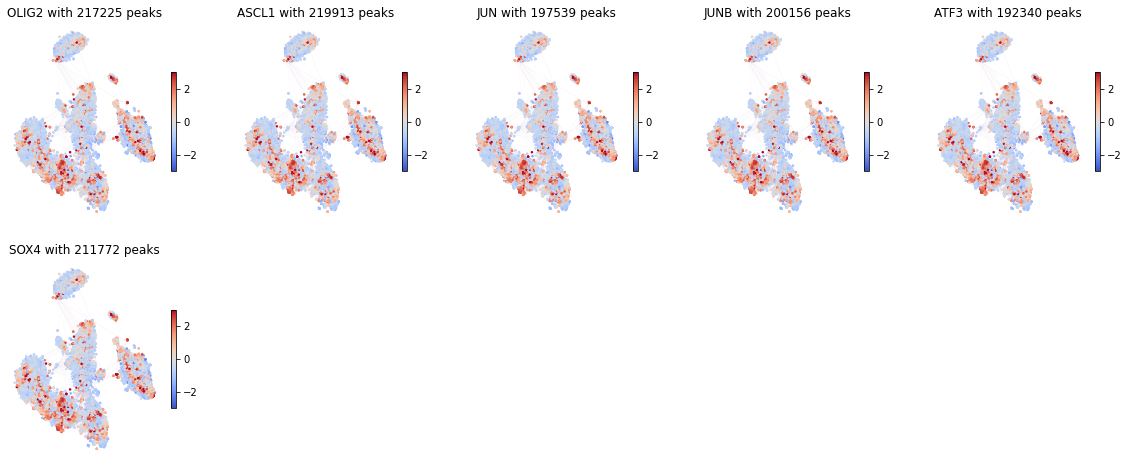

In [7]:
# from chromograph.plotting.motif_plot import motif_plot

markers = ['OLIG2', 'ASCL1', 'JUN', 'JUNB', 'ATF3', 
           'SOX4',]

with loompy.connect(f_motif, 'r') as ds:
    for marker in markers:
        if marker not in ds.ra.Gene:
            logging.info(f"Can't find {marker}")

with loompy.connect(f_motif, 'r') as ds:
    motif_plot(ds, '/home/camiel/misc/tumor_motifs.png', markers, 'TSNE', layer='MZ')

## Overlay with conservation scores

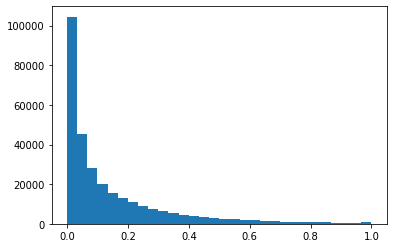

In [8]:
def get_conservation_score(ds):
    '''
    Overlays peaks of PeakxCell matrix with phastcon100way reference to estimate estimate evolutionaryconservation.
    
    Args:
        ds        LoomConnection with 'ID', 'Chr', 'Start' and 'End' row attributes
        
    Returns
        out       np.array or shape ds.shape[1] containing conservation scores
    '''
    BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in range(ds.shape[0])]).saveas('input.bed')
    subprocess.call(['/home/camiel/anaconda3/envs/chromo/bin/bigWigAverageOverBed', '/datb/sl/camiel/scATAC/ref/hg38.phastCons100way.bw', 'input.bed', 'out.tab'])
    tab = np.loadtxt('out.tab', dtype=str, delimiter='\t')

    ## Cleanup
    subprocess.call(['rm', 'input.bed', 'out.tab'])

    return np.array(tab[:,-1].astype('float'))

with loompy.connect(f_agg, 'r+') as dsagg:    
    dsagg.ra.ConservationScore = get_conservation_score(dsagg)
    
    plt.hist(dsagg.ra.ConservationScore, bins=30)

In [26]:
def trim_by_conservation(enhancers: BedTool, s:int=300, max_plots = 0):
    trimmed = []
    plot = 0
    
    for enhancer in enhancers:
        enhancer_bed = f'{enhancer[3]}.bed'
        out_tab = f'{enhancer[3]}.tab'
        bases = BedTool([(enhancer[0], x, x+1, x) for x in range(int(enhancer[1])-1, int(enhancer[2]))]).saveas(enhancer_bed)
        subprocess.call(['/home/camiel/anaconda3/envs/chromo/bin/bigWigAverageOverBed', '/datb/sl/camiel/scATAC/ref/hg38.phastCons100way.bw', enhancer_bed, out_tab])
        tab = np.loadtxt(out_tab, dtype=str, delimiter='\t')
        con = tab[:,-1].astype(float)
        
        n_windows = len(con) - s
        
        if n_windows >= 1:
            score = [np.sum(con[x:x+s])for x in range(n_windows)]
            sel = np.where(score == np.max(score))[0][0]
            
            if plot < max_plots:
                # plot figure
                fig, ax = plt.subplots(2,1)
                ax[0].plot(con)
                ax[0].axvline(sel, c='red')
                ax[0].axvline(sel+s, c='red')
                ax[1].plot(np.linspace(np.round(s/2), n_windows+np.round(s/2), n_windows), score)
                ax[1].set_xlim(0,len(con))
                plot += 1
            
            ch, st, en = enhancer[0], int(enhancer[1])+sel, int(enhancer[1])+sel+s
            trimmed.append([ch, st, en, f'{ch}:{st}-{en}'])
        else:
            trimmed.append([enhancer[x] for x in range(4)])

        subprocess.call(['rm', enhancer_bed, out_tab])
        
    return BedTool([[x[0], str(x[1]),str(x[2]), x[3]] for x in trimmed])

## Selecting positive peaks in PNs, MES, INM and 'All tumor'

In [10]:
## There is no annotation available for the data (no cluster labels nor the CNV tumor/healthy score from CONICS) so we use the markers to select the populations

# MES = [18, 19, 20]  ## I included these clusters rather than 22, 23 as the MES cluster discussed in paper since 
#                     ## they have a high score for CD44, even though both groups score high on AQP4/GFAP
# INM = [14, 16, 17]
# PN = [21]
# IDH = [9, 10, 11, 12, 13]

# GLIOMA = np.sort(np.hstack([PN, MES, INM, IDH]))

MES = [11,16,17]
INM = [15,18]
PN = [12, 13, 14]
GLIOMA = np.sort(np.hstack([PN, MES, INM]))

In [11]:
control_elements = ['/datb/sl/camiel/tumor/Healthy_tissues_scATAC/active_elements/Corces.hg38.bed', 
                    '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/active_elements/Greenleaf.hg38.bed']

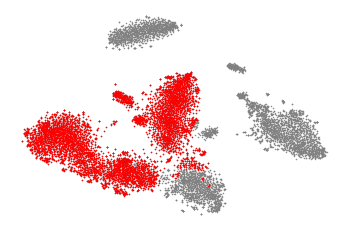

In [12]:
emb = 'TSNE'
with loompy.connect(f_GA, 'r') as ds:
    v = np.array([x in GLIOMA for x in ds.ca.Clusters])
    plt.scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], s=1, c='gray', marker='.')
    plt.scatter(ds.ca[emb][v,0], ds.ca[emb][v,1], s=1, c='red', marker='.')
    plt.axis("off")
    plt.savefig(f'/home/camiel/misc/Glioma_TSNE.png')

In [13]:
def remove_elements(ds, reference):
    '''
    Removes promoters, CTCF binding sites and the UCSC blacklist from the selected peaks
    '''
    peak_list = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in range(len(ds.ra['Chr']))]).saveas()
    for x in ['promoter', 'ctcf', 'blacklist']:
        sub = BedTool(os.path.join(reference, 'regions', f'{x}.bed'))
        peak_list = peak_list.subtract(sub, A=True)
    enh_peaks = [x[3] for x in peak_list]
    Valid = [x in enh_peaks for x in ds.ra.ID]
    
    return np.array(Valid)

def jaccard_heatmap(x, labels):
    '''
    Plot jaccard similarity between arrays
    '''
    m = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(i, len(x)):
            m[i,j] = jaccard(x[i], x[j])
            m[j,i] = m[i,j]
        m[i,i] = 1
    m = 1 - m
    
    fig, ax = plt.subplots(1,1)
    im = ax.imshow(m)
    im = ax.imshow(m, extent=[-1,1,-1,1])
    Irange = np.linspace(-1+(1/len(labels)),1-(1/len(labels)),len(labels))
    Jrange = np.linspace(1-(1/len(labels)),-1+(1/len(labels)),len(labels))
    ax.set_xticks(Irange)
    ax.set_yticks(Jrange)
    ax.set_xticklabels(labels, rotation=45, rotation_mode="anchor", ha="right")
    ax.set_yticklabels(labels)
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(x)):
        for j in range(len(x)):
            text = ax.text(Irange[i], Jrange[j], np.round(m[i, j],3),
                           ha="center", va="center", color="w", weight = 'bold')

## Annotated enhancers only

In [14]:
def isolate_enhancers(ds, reference):
    '''
    Remove all elements that do not overlap an annotated enhancer form the GENCODE dataset
    '''
    peak_list = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in range(len(ds.ra['Chr']))]).saveas()
    enhancers = BedTool(reference)
    peak_list = peak_list.intersect(enhancers, wa=True)
    enh_peaks = [x[3] for x in peak_list]
    Valid = [x in enh_peaks for x in ds.ra.ID]
    
    return np.array(Valid)

13:03:03 INFO     [12, 13, 14] valid: 11913
13:03:03 INFO     [11, 16, 17] valid: 8948
13:03:03 INFO     [15, 18] valid: 15173
13:03:03 INFO     [11 12 13 14 15 16 17 18] valid: 7647
13:03:08 INFO     631 enhancers after filtering potential cross activation
13:03:13 INFO     775 enhancers after filtering potential cross activation
13:03:26 INFO     3266 enhancers after filtering potential cross activation
13:03:30 INFO     423 enhancers after filtering potential cross activation


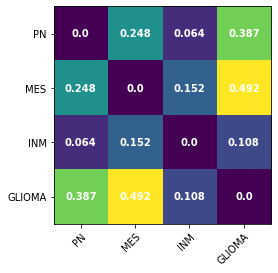

In [15]:
with loompy.connect(f_agg, 'r') as dsagg:
    logging.info(f'Shape aggregate: {dsagg.shape}')
    selection = isolate_enhancers(dsagg, os.path.join(config.paths.ref, 'regions', f'enhancer.bed'))
    selection = (selection) & (dsagg.ra.Chr != 'chrY') ## Remove the Y chromosome
    
    ## Select peaks that are accessible across clusters and follow the selection criteria
    threshold = 5
    Valids_enh = []
    d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
    binary = dsagg['CPM'][:,:]/(d/1000).reshape((d.shape[0],1)) > threshold  ## Normalize for peak size since peaks in our pipeline have variable size
    for population in [PN, MES, INM, GLIOMA]:
        mu = np.mean(binary[:,population], axis=1)
        Valids_enh.append(np.logical_and(selection, mu > 0.8))
        logging.info(f'{population} valid: {np.sum(Valids_enh[-1])}')

    ## Remove elements overlapping with the Lake (adult brain) and Greenleaf (hematopoiesis) datasets
    candidates_enh = []
    for v in Valids_enh:
        subset = BedTool([(dsagg.ra['Chr'][x], str(dsagg.ra['Start'][x]), str(dsagg.ra['End'][x]), str(dsagg.ra['ID'][x])) for x in np.where(v)[0]]).saveas()
        for f in control_elements:  ## Processed seperately peaks are all 500 bp and if any cluster has > 1 CPM it is marked as active
            control = BedTool(f)
            subset = subset.subtract(control, A=True)
        peaks = [x[3] for x in subset]
        candidates_enh.append(np.array([x in peaks for x in dsagg.ra.ID]))
        logging.info(f'{len(peaks)} enhancers after filtering potential cross activation')        
        
jaccard_heatmap(candidates_enh, labels = ['PN', 'MES', 'INM', 'GLIOMA'])
plt.savefig('/home/camiel/misc/enhancers_jaccard_annotated.png')

13:03:35 INFO     Selected 100 out of 631 valids
13:03:35 INFO     Selected 100 out of 775 valids
13:03:35 INFO     Selected 100 out of 3266 valids
13:03:35 INFO     Selected 100 out of 423 valids
13:03:36 INFO     Selected 100 out of 631 valids
13:03:37 INFO     Selected 100 out of 775 valids
13:03:37 INFO     Selected 100 out of 3266 valids
13:03:37 INFO     Selected 100 out of 423 valids


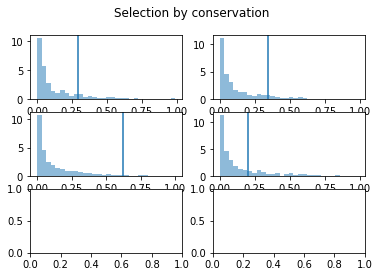

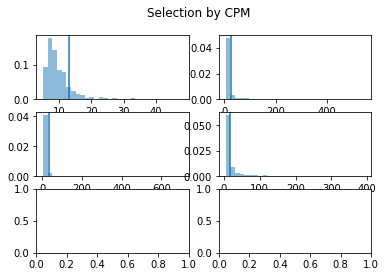

In [16]:
N_candidates = 100

## Select the top N condidates based on conservation score
with loompy.connect(f_agg, 'r') as dsagg:
    enh_by_cons = []
    
    fig, ax = plt.subplots(2,2)
    ax = ax.flatten()
    for i, x in enumerate(candidates_enh):
        q = np.quantile(dsagg.ra.ConservationScore[x], 1-(N_candidates/np.sum(x)))
        enh_by_cons.append((x) & (dsagg.ra.ConservationScore > q))
        
        ## Plot
        ax[i].hist(dsagg.ra.ConservationScore[x], bins = 30, density=True, alpha=.5)
        ax[i].axvline(q)
        logging.info(f'Selected {np.sum(enh_by_cons[-1])} out of {np.sum(x)} valids')
    fig.suptitle('Selection by conservation')

## Select the top N candidates based on average cluster accessibility        
with loompy.connect(f_agg, 'r') as dsagg:
    enh_by_CPM = []
    
    fig, ax = plt.subplots(2,2)
    ax = ax.flatten()
    for i, (population, x) in enumerate(zip([PN, MES, INM, GLIOMA], candidates_enh)):
        ## Get the means across clusters and normalize against peaksize
        mu = np.mean(dsagg['CPM'][:,population], axis=1)
        d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
        mu = mu/ (d/1000)
        
        q = np.quantile(mu[x], 1-(N_candidates/np.sum(x)))
        enh_by_CPM.append((x) & (mu > q))
        
        ## Plot
        ax[i].hist(mu[x], bins = 30, density=True, alpha=.5)
        ax[i].axvline(q)
        logging.info(f'Selected {np.sum(enh_by_CPM[-1])} out of {np.sum(x)} valids')
    fig.suptitle('Selection by CPM')


jaccard similarity with conservation: 0.3223684210526315 and by CPM: 0.3137254901960784
jaccard similarity with conservation: 0.26582278481012656 and by CPM: 0.2738853503184714
jaccard similarity with conservation: 0.12994350282485878 and by CPM: 0.09890109890109888
jaccard similarity with conservation: 0.39583333333333337 and by CPM: 0.39583333333333337


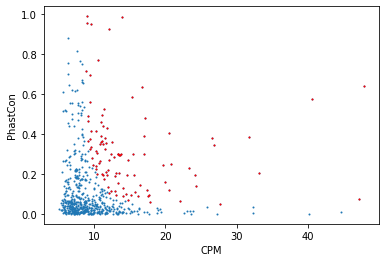

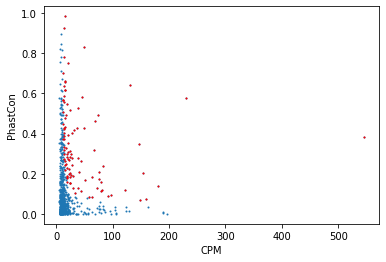

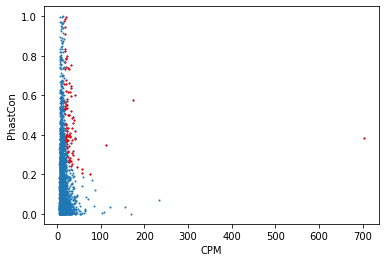

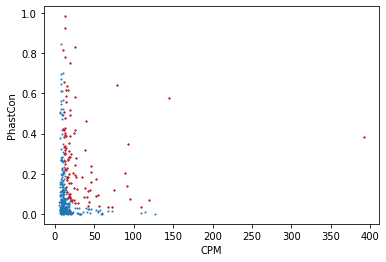

In [17]:
## Selection by ranked consensus, takes into account both CPM and conservation score

import scipy.stats as ss

N_candidates =100

with loompy.connect(f_agg, 'r') as dsagg:
    enh_by_consensus = []

    for i, (population, x) in enumerate(zip([PN, MES, INM, GLIOMA], candidates_enh)):
        IDs = dsagg.ra.ID[x]
        con = dsagg.ra.ConservationScore[x]
        
        ## Get the means across clusters and normalize against peaksize
        mu = np.mean(dsagg['CPM'][:,population], axis=1)
        d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
        mu = mu/ (d/1000)
        CPM = mu[x]
        
        ## Rank data by conservation score and CPM
        r1 = ss.rankdata(con)
        r2 = ss.rankdata(CPM)
        
        ## Multiply ranks
        rank = r1+r2
        q = np.quantile(rank, 1-(N_candidates/len(rank)))
        
        fig, ax = plt.subplots(1,1)
        ax.scatter(CPM, con, s=1)
        ax.scatter(CPM[rank >= q], con[rank >= q], s=1, c='red')
        ax.set_xlabel('CPM')
        ax.set_ylabel('PhastCon')

        v_IDs = IDs[rank >= q]
        enh_by_consensus.append([x in v_IDs for x in dsagg.ra.ID])
        
        print(f'jaccard similarity with conservation: {1-jaccard(enh_by_consensus[i], enh_by_cons[i])} and by CPM: {1-jaccard(enh_by_consensus[i], enh_by_CPM[i])}')

## Selecting unlabeled enhancers 

13:14:57 INFO     [12, 13, 14] valid: 18398
13:14:57 INFO     [11, 16, 17] valid: 14220
13:14:57 INFO     [15, 18] valid: 23433
13:14:57 INFO     [11 12 13 14 15 16 17 18] valid: 12134
13:15:02 INFO     415 enhancers after filtering potential cross activation
13:15:09 INFO     542 enhancers after filtering potential cross activation
13:15:32 INFO     1426 enhancers after filtering potential cross activation
13:15:36 INFO     285 enhancers after filtering potential cross activation


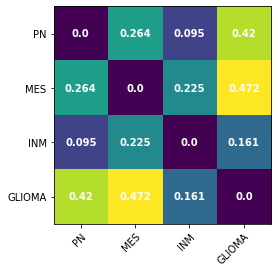

In [18]:
with loompy.connect(f_agg, 'r') as dsagg:    
    
    ## Remove some known elements that we aren't interested in
    selection = remove_elements(dsagg, config.paths.ref)
    selection = (selection) & (dsagg.ra.Chr != 'chrY') ## Remove the Y chromosome

    ## Select peaks that are accessible across clusters and follow the selection criteria
    threshold = 5
    Valids = []
    mus = []
    d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
    binary = dsagg['CPM'][:,:]/(d/1000).reshape((d.shape[0],1)) > threshold
    
    for population in [PN, MES, INM, GLIOMA]:
        mu = np.mean(binary[:,population], axis=1)
        mus.append(mu)
        Valids.append(np.logical_and(selection, mu > 0.8))
        logging.info(f'{population} valid: {np.sum(Valids[-1])}')

    ## Remove elements overlapping with the Lake (adult brain) and Greenleaf (hematopoiesis) datasets
    candidates = []
    for i, v in enumerate(Valids):
        subset = BedTool([(dsagg.ra['Chr'][x], str(dsagg.ra['Start'][x]), str(dsagg.ra['End'][x]), str(dsagg.ra['ID'][x])) for x in np.where(v)[0]]).saveas()
        for f in control_elements:
            control = BedTool(f)
            subset = subset.subtract(control, A=True)
        peaks = [x[3] for x in subset]
        peak_bin = np.array([x in peaks for x in dsagg.ra.ID])
        peak_bin[np.where(np.array(candidates_enh[i]) == True)[0]] = False    ## Only select peaks not already annotated
        candidates.append(peak_bin)
        logging.info(f'{np.sum(peak_bin)} enhancers after filtering potential cross activation')
    
jaccard_heatmap(candidates, labels = ['PN', 'MES', 'INM', 'GLIOMA'])
plt.savefig('/home/camiel/misc/enhancers_jaccard_free.png')

13:15:41 INFO     Selected 100 out of 415 valids
13:15:41 INFO     Selected 100 out of 542 valids
13:15:41 INFO     Selected 100 out of 1426 valids
13:15:41 INFO     Selected 100 out of 285 valids
13:15:42 INFO     Selected 100 out of 415 valids
13:15:42 INFO     Selected 100 out of 542 valids
13:15:43 INFO     Selected 100 out of 1426 valids
13:15:43 INFO     Selected 100 out of 285 valids


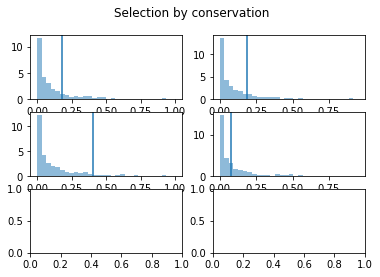

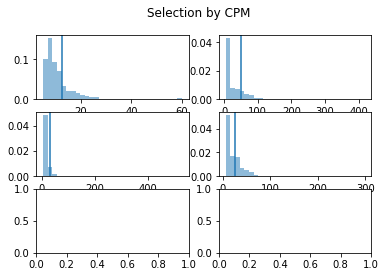

In [19]:
N_candidates = 100

## Select the top N condidates based on conservation score
with loompy.connect(f_agg, 'r') as dsagg:
    can_by_cons = []
    
    fig, ax = plt.subplots(2,2)
    ax = ax.flatten()
    for i, x in enumerate(candidates):
        q = np.quantile(dsagg.ra.ConservationScore[x], 1 - (N_candidates/np.sum(x)))
        can_by_cons.append((x) & (dsagg.ra.ConservationScore > q))
        
        ## Plot
        ax[i].hist(dsagg.ra.ConservationScore[x], bins = 30, density=True, alpha=.5)
        ax[i].axvline(q)
        logging.info(f'Selected {np.sum(can_by_cons[-1])} out of {np.sum(x)} valids')
    fig.suptitle('Selection by conservation')

## Select the top N condidates based on average accessibility across clusters
with loompy.connect(f_agg, 'r') as dsagg:
    can_by_CPM = []
    
    fig, ax = plt.subplots(2,2)
    ax = ax.flatten()
    for i, (population, x) in enumerate(zip([PN, MES, INM, GLIOMA], candidates)):
        
        ## Get the means across clusters and normalize against peaksize
        mu = np.mean(dsagg['CPM'][:,population], axis=1)
        d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
        mu = mu/ (d/1000)
        
        q = np.quantile(mu[x], 1 - (N_candidates/np.sum(x)))
        can_by_CPM.append((x) & (mu > q))
        
        ## Plot
        ax[i].hist(mu[x], bins = 30, density=True, alpha=.5)
        ax[i].axvline(q)
        logging.info(f'Selected {np.sum(can_by_CPM[-1])} out of {np.sum(x)} valids')
    fig.suptitle('Selection by CPM')

jaccard similarity with conservation: 0.39860139860139865 and by CPM: 0.33333333333333337
jaccard similarity with all candidates: 0.24096385542168675
jaccard similarity with conservation: 0.25 and by CPM: 0.29032258064516125
jaccard similarity with all candidates: 0.18450184501845024
jaccard similarity with conservation: 0.19760479041916168 and by CPM: 0.19760479041916168
jaccard similarity with all candidates: 0.07012622720897621
jaccard similarity with conservation: 0.4925373134328358 and by CPM: 0.39860139860139865
jaccard similarity with all candidates: 0.3508771929824561


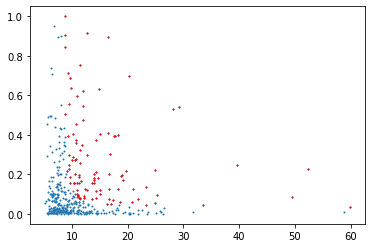

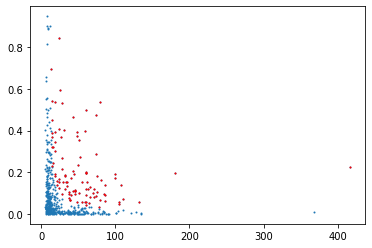

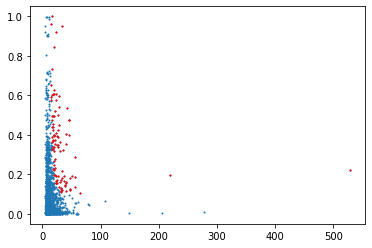

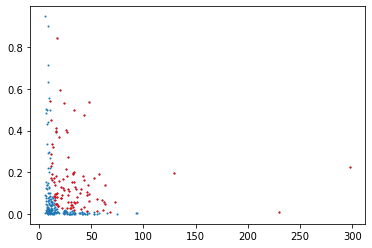

In [20]:
## Selection by ranked consensus
import scipy.stats as ss

N_candidates = 100

with loompy.connect(f_agg, 'r') as dsagg:
    can_by_consensus = []

    for i, (population, x) in enumerate(zip([PN, MES, INM, GLIOMA], candidates)):
        IDs = dsagg.ra.ID[x]
        con = dsagg.ra.ConservationScore[x]
        
        ## Get the means across clusters and normalize against peaksize
        mu = np.mean(dsagg['CPM'][:,population], axis=1)
        d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
        mu = mu/ (d/1000)
        CPM = mu[x]
        
        ## Rank data by conservation score and CPM
        r1 = ss.rankdata(con)
        r2 = ss.rankdata(CPM)
        
        ## Multiply ranks
        rank = r1*r2
        q = np.quantile(rank, 1-(N_candidates/len(rank)))
        
        fig, ax = plt.subplots(1,1)
        ax.scatter(CPM, con, s=1)
        ax.scatter(CPM[rank >= q], con[rank >= q], s=1, c='red')

        v_IDs = IDs[rank >= q]
        can_by_consensus.append([x in v_IDs for x in dsagg.ra.ID])
        
        print(f'jaccard similarity with conservation: {1-jaccard(can_by_consensus[i], can_by_cons[i])} and by CPM: {1-jaccard(can_by_consensus[i], can_by_CPM[i])}')
        print(f'jaccard similarity with all candidates: {1-jaccard(can_by_consensus[i], candidates[i])}')


## Metrics

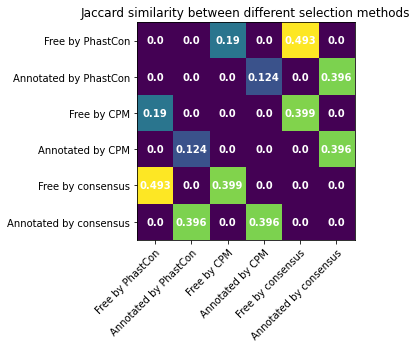

In [21]:
## Sanity check. There should be no overlap between the 'Free' and 'annotated' groups

glioma_candidates = [can_by_cons[-1], enh_by_cons[-1], can_by_CPM[-1], enh_by_CPM[-1], can_by_consensus[-1], enh_by_consensus[-1]]
labels = ['Free by PhastCon', 'Annotated by PhastCon', 'Free by CPM', 'Annotated by CPM', 'Free by consensus', 'Annotated by consensus']

jaccard_heatmap(glioma_candidates, labels = labels)
plt.title(f'Jaccard similarity between different selection methods')
plt.savefig('/home/camiel/misc/enhancers_jaccard_methods.png')

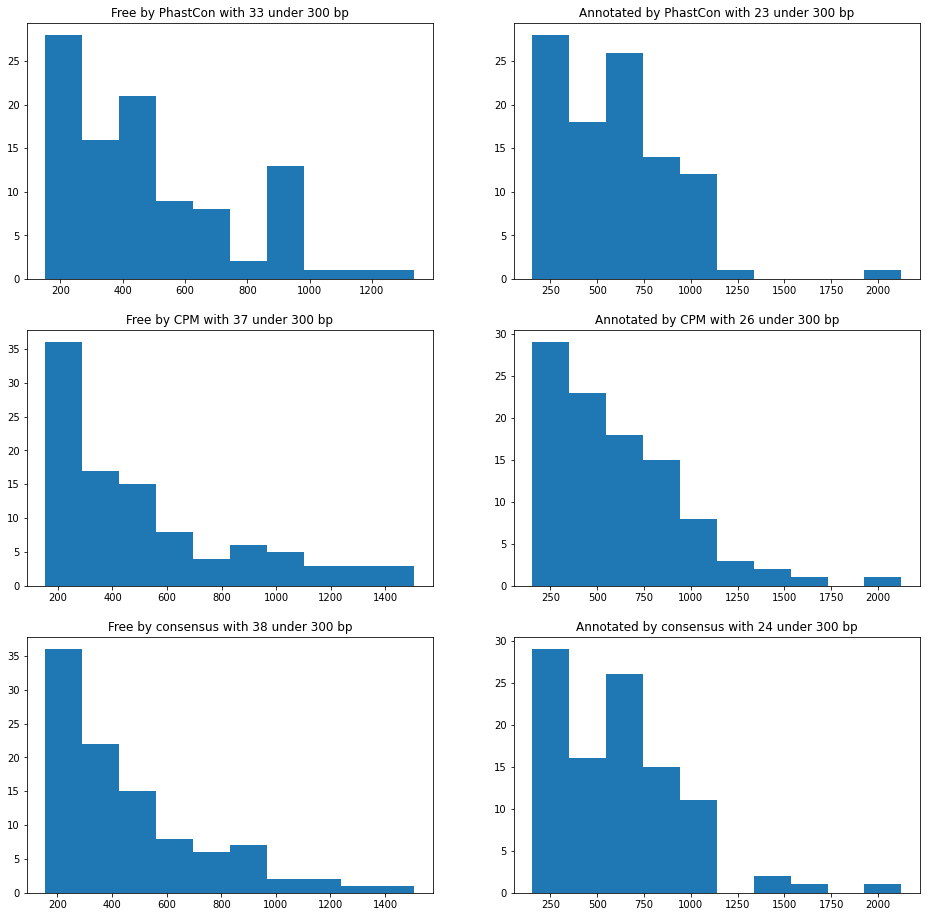

In [22]:
## Plot fragment sizes for each selection method for the GLIOMA set
with loompy.connect(f_agg, 'r') as dsagg:
    fig, ax = plt.subplots(3,2, figsize=(16,16))
    ax = ax.flatten()
    
    for i, (x, y) in enumerate(zip(glioma_candidates, labels)):
        d = dsagg.ra.End[x].astype('int') - dsagg.ra.Start[x].astype('int')
        
        ax[i].hist(d)
        ax[i].set_title(f'{y} with {np.sum(d<300)} under 300 bp')
        
    plt.savefig('/home/camiel/misc/enhancers_length.png')

In [23]:
## Select final set
Selected_enhancers = np.array(can_by_consensus[-1]) | np.array(enh_by_consensus[-1])
np.sum(Selected_enhancers)

201

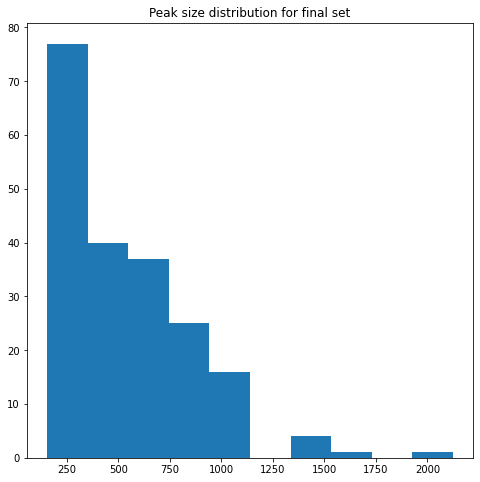

In [24]:
## Plot the fragment sizes
with loompy.connect(f_agg, 'r') as dsagg:
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    
    d = dsagg.ra.End[Selected_enhancers].astype('int') - dsagg.ra.Start[Selected_enhancers].astype('int')

    ax.hist(d)
    ax.set_title(f'Peak size distribution for final set')
        
    plt.savefig('/home/camiel/misc/enhancers_length.png')

2.2682983568315773
167


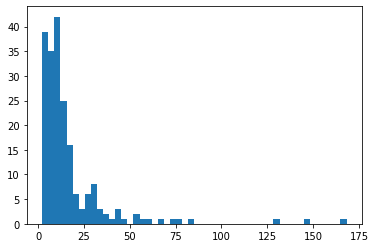

In [48]:
## Plot CPM
with loompy.connect(f_agg, 'r') as dsagg:
    X = np.mean(dsagg['CPM'][:,GLIOMA], axis=1)[Selected_enhancers]
    plt.hist(X, bins=50)
    print(np.min(X))
    print(np.sum(X>5))

13:30:42 INFO     Trimmed enhancers


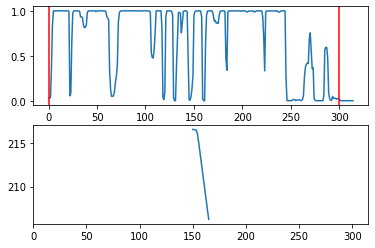

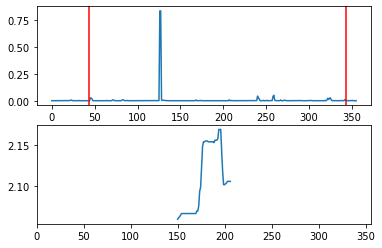

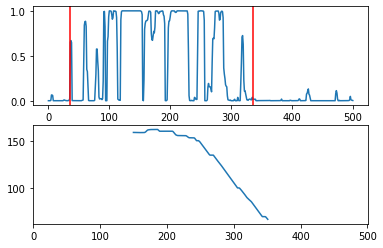

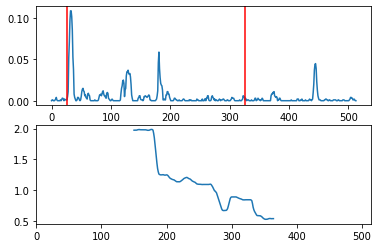

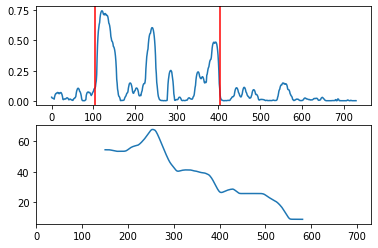

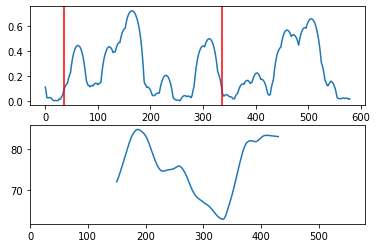

In [31]:
## Extract the most conserved region from peaks larger than 300 bp
with loompy.connect(f_agg, 'r') as dsagg:
    enhancers = BedTool([(dsagg.ra.Chr[x], str(dsagg.ra.Start[x]), str(dsagg.ra.End[x]), dsagg.ra.ID[x]) for x in np.where(Selected_enhancers)[0]])
    trimmed_enhancers = trim_by_conservation(enhancers, max_plots=6).saveas(f'/datb/sl/camiel/tumor/outputs/enhancers_{date}.bed')
    logging.info(f'Trimmed enhancers')
    plt.savefig('/home/camiel/misc/enhancer_trimming.png')

In [32]:
## Get fasta files
fasta = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/fasta/genome.fa'
trimmed_enhcancers = trimmed_enhancers.sequence(fi=fasta)

sq = open(trimmed_enhancers.seqfn).read().split('\n')
sq = list(filter(None, sq))

In [33]:
## Save table to txt file
table = np.array(sq).reshape(int(len(sq)/2),2)
np.savetxt(f'/datb/sl/camiel/tumor/outputs/enhancers_{date}.txt', table, fmt='%s', delimiter='\t')

22:04:32 INFO     Added enhancers to list
22:04:34 INFO     Added enhancers to list


301

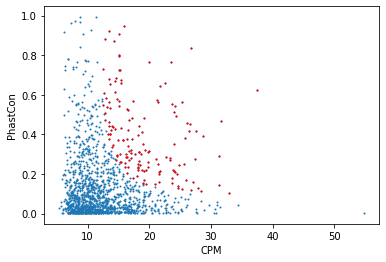

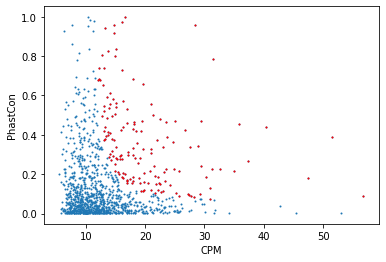

In [25]:
## Additional enhancers
N_candidates = 150

with loompy.connect(f_agg, 'r') as dsagg:
    output = []

    for x in [candidates_enh[-1], candidates[-1]]:
        IDs = dsagg.ra.ID[x]
        con = dsagg.ra.ConservationScore[x]
        
        ## Get the means across clusters and normalize against peaksize
        mu = np.mean(dsagg['CPM'][:,GLIOMA], axis=1)
        d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
        mu = mu/ (d/1000)
        CPM = mu[x]
        
        ## Rank data by conservation score and CPM
        r1 = ss.rankdata(con)
        r2 = ss.rankdata(CPM)
        
        ## Multiply ranks
        rank = r1+r2
        q = np.quantile(rank, 1-(N_candidates/len(rank)))
        
        fig, ax = plt.subplots(1,1)
        ax.scatter(CPM, con, s=1)
        ax.scatter(CPM[rank >= q], con[rank >= q], s=1, c='red')
        ax.set_xlabel('CPM')
        ax.set_ylabel('PhastCon')

        v_IDs = IDs[rank >= q]
        output.append([x in v_IDs for x in dsagg.ra.ID])
        
        logging.info(f'Added enhancers to list')

## Select final set
Added = np.array(output[0]) | np.array(output[1])
Added[np.where(Selected_enhancers)[0]] = False
print(np.sum(Added))

In [33]:
with loompy.connect(f_agg, 'r') as dsagg:
    added_enh = BedTool([(dsagg.ra.Chr[x], str(dsagg.ra.Start[x]), str(dsagg.ra.End[x]), dsagg.ra.ID[x]) for x in np.where(Added)[0]])
    extra_enhancers = trim_by_conservation(added_enh).saveas('/data/proj/tumor/Kriegstein/outputs/enhancers_extra.bed')

## Get fasta files
fasta = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/fasta/genome.fa'
extra_enhancers = extra_enhancers.sequence(fi=fasta)

sq = open(extra_enhancers.seqfn).read().split('\n')
sq = list(filter(None, sq))

## Save table to txt file
table = np.array(sq).reshape(int(len(sq)/2),2)
np.savetxt('/data/proj/tumor/Kriegstein/outputs/enhancers_extra.txt', table, fmt='%s', delimiter='\t')